# Bevezetés

Ez a notebook egy **demo projekt**, amely bemutatja a Python `seaborn` könyvtárának használatát különböző adatvizualizációkhoz.  

A célja:  

- Szintetikus adatok generálása filmekről, felhasználókról és véleményekről a `Faker` könyvtár segítségével.  
- Az adatok feldolgozása és táblázatba rendezése `pandas` DataFrame-ekben.  
- Különböző statisztikai és vizuális elemzések bemutatása, például:  
  - Átlagos értékelések műfaj, korcsoport és nem szerint  
  - Vélemények időbeli alakulása  
  - Korrelációk és hőtérképek  

Ez a notebook **oktatási és demonstrációs célokat szolgál**, így a generált adatok nem valósak, viszont jól szemléltetik, hogyan lehet a `seaborn` és `matplotlib` eszközeit használni **adatvizualizációra és elemzésre**.  

Az itt bemutatott módszerek könnyen alkalmazhatók valós adatokra is, ha később igazi datasetekkel szeretnénk dolgozni.


In [58]:
# Függőségek telepítése és a megfelelő függvények meghívása
!pip install -r requirements.txt
from src.data.basic.generator import generate_people, generate_reviews, generate_movies

# Adatok generálása

Ebben a notebookban szintetikus adatokat hozunk létre a vizualizációkhoz és elemzésekhez:

- **Emberek:** 300 felhasználó, magyar nevekkel és városokkal, életkor 10-80 év között, kb. fele férfi, fele nő.
- **Filmek:** 70 film, angol címek, megjelenési év 1980-2025 között.
- **Vélemények:** 1000 vélemény véletlenszerűen választott felhasználóktól és filmektől, értékelés 1-5 között, szöveges vélemények magyar nyelven.

A generált adatok biztosítják, hogy a következő vizualizációkhoz és elemzésekhez teljesen működő, szintetikus adatkészlet álljon rendelkezésre.


In [59]:
# Emberek generálása
people = generate_people(
    n=300,
    male_ratio=0.5,
    locale="hu_HU",
    unique=True,
    min_age=10,
    max_age=80
)

# Filmek generálása
movies = generate_movies(
    n=70,
    locale="en_US",
    unique=True,
    year_min=1980,
    year_max=2025
)

# Vélemények generálása
reviews = generate_reviews(
    n=1000,
    people=people,
    movies=movies,
    locale="hu_HU",
    unique=False,   
    min_rating=1,
    max_rating=5
)


# DataFrame-ek létrehozása és összekapcsolása

Ebben a lépésben a generált listákból (`people`, `movies`, `reviews`) **pandas DataFrame-eket** készítünk, majd azokat **egyesítjük**, hogy minden véleményhez hozzákapcsoljuk a felhasználó és a film adatait.

- `df_people` → felhasználók adatai
- `df_movies` → filmek adatai
- `df_reviews` → vélemények adatai
- `df_full` → egyesített DataFrame, amely tartalmazza a vélemény, felhasználó és film összes releváns információját

Az összekapcsolást **JOIN-okkal** végezzük a `person_id` és `movie_id` kulcsok alapján.


In [68]:
import pandas as pd



# Alap DataFrame-ek
df_people = pd.DataFrame([p.__dict__ for p in people])
df_movies = pd.DataFrame([m.__dict__ for m in movies])
df_reviews = pd.DataFrame([r.__dict__ for r in reviews])

# Oszlopnevek tisztítása
df_people.rename(columns={
    "person_id": "person_id",
    "name": "person_name",
    "age": "person_age",
    "city": "person_city",
    "male": "person_male"
}, inplace=True)

df_movies.rename(columns={
    "movie_id": "movie_id",
    "title": "movie_title",
    "year": "movie_year",
    "genre": "movie_genre"
}, inplace=True)

# Összekapcsolás (JOIN-ok)
df_full = (
    df_reviews
    .merge(df_people, on="person_id", how="left")
    .merge(df_movies, on="movie_id", how="left")
)

# Ellenőrzés
print(f"Egyesített DataFrame mérete: {df_full.shape}")
print("\nMinta:")
display(df_full.head(5))


Egyesített DataFrame mérete: (1000, 13)

Minta:


,review_id,person_id,movie_id,rating,text,date,person_name,person_age,person_city,person_male,movie_title,movie_year,movie_genre
0,1,196,24,1,Vero eveniet officia unde cumque voluptatum fu...,2025-03-20,Dr. Tóth Csaba Attila,18,Borsodfürdőbánya,True,Provide,2022,Fantasy
1,2,269,66,3,Enim voluptas dignissimos distinctio natus adi...,2025-01-25,M. Sárközi Anna,39,Alsóberény,False,Participant from,2023,Romance
2,3,246,29,2,Natus tempora doloribus nobis in veritatis. Co...,2025-07-17,Varga O. István,30,Nagyhídváros,True,Herself painting,2022,Drama
3,4,283,69,4,Veniam sed dolore ea. Quibusdam voluptatem quo...,2025-01-24,P. Nagy Gergő,28,Lajostótdevecser,True,Dinner always by,1993,Comedy
4,5,114,7,4,Perspiciatis quam rerum. Tempore dolorem quibu...,2025-10-10,J. Kozma Máté,47,Mosontótkőrös,True,Major college what,1990,Horror


# Vizualizáció előkészítése

Ebben a lépésben importáljuk a szükséges könyvtárakat és beállítjuk az alapértelmezett stílust a grafikonokhoz:

- **Matplotlib** és **Seaborn**: a fő eszközeink a vizualizációhoz.
- **Stílus beállítások Seaborn-ban**:
  - `style="whitegrid"` → világos rácsvonalas háttér a könnyebb olvashatóság érdekében.
  - `palette="pastel"` → pasztellszínek az oszlopokhoz és vonalakhoz.
  - `font_scale=1.1` → kicsit nagyobb betűméret a címekhez és tengelyekhez.

Ezután érdemes gyorsan ellenőrizni a `df_full` oszlopait, hogy lássuk, milyen változókkal fogunk dolgozni a vizualizációk során

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Alap stílus
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Ellenőrizzük az adatokat
print(df_full.columns)

Index(['review_id', 'person_id', 'movie_id', 'rating', 'text', 'date',
       'person_name', 'person_age', 'person_city', 'person_male',
       'movie_title', 'movie_year', 'movie_genre'],
      dtype='object')


# Átlagos értékelés műfajonként

Ebben a lépésben azt vizualizáljuk, hogy az egyes film műfajokhoz tartozó vélemények **átlagosan milyen értékelést kaptak**.

- **Adatok:** `df_full` DataFrame, amely tartalmazza a véleményeket és a filmek műfaját.  
- **Vizualizáció típusa:** oszlopdiagram (`barplot`) a Seaborn könyvtárral.  
- **Beállítások:**
  - `estimator="mean"` → az oszlopok az átlagos értékelést mutatják.
  - `hue="movie_genre"` és `dodge=False` → minden műfaj külön színben, oszlopok egy helyen.
  - `palette="crest"` → pasztell színátmenet a műfajokhoz.
  - `errorbar=None` → hibasávok eltávolítva a tisztább ábra érdekében.
  - `xticks(rotation=45)` → a műfajnevek olvashatóbbak elforgatva.
  - `plt.legend([],[], frameon=False)` → a legenda eltüntetve, mert a színek és az x tengely alapján egyértelmű a műfaj.

Ez az ábra segít gyorsan áttekinteni, hogy **melyik műfaj kapta a legmagasabb vagy legalacsonyabb átlagos értékelést**.


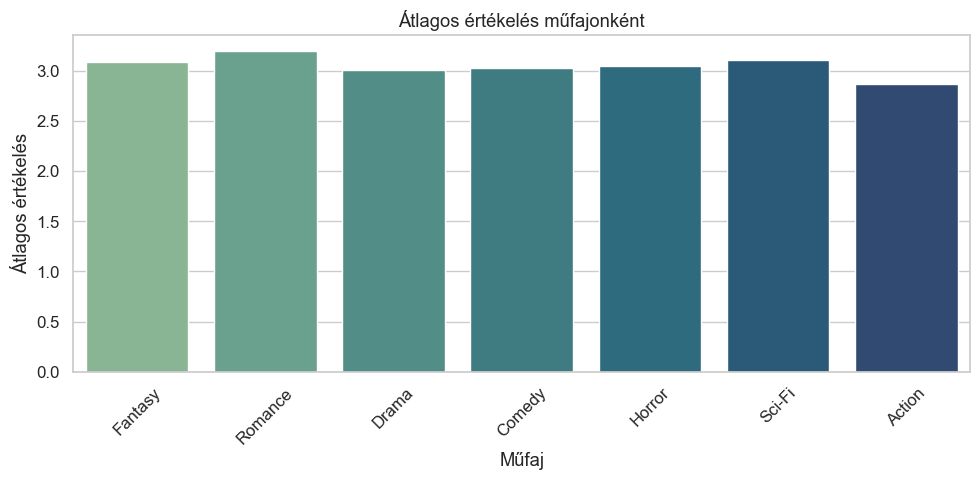

In [62]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_full,
    x="movie_genre",
    y="rating",
    estimator="mean",
    hue="movie_genre",   
    dodge=False,         
    palette="crest",
    errorbar=None
)
plt.title("Átlagos értékelés műfajonként")
plt.ylabel("Átlagos értékelés")
plt.xlabel("Műfaj")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


# Átlagos értékelés nemek szerint

Ebben a vizualizációban azt nézzük meg, hogy a felhasználók neme milyen hatással van az átlagos filmértékelésre.

- **Adatok:** `df_full` DataFrame, amely tartalmazza a véleményeket és a felhasználók nemét (`person_male`).
- **Vizualizáció típusa:** oszlopdiagram (`barplot`) a Seaborn könyvtárral.
- **Beállítások:**
  - `estimator="mean"` → az oszlopok az átlagos értékelést mutatják.
  - `palette="Set2"` → a férfiak és nők átlagai külön színnel kiemelve.
  - `errorbar=None` → hibasávok eltávolítva a tisztább ábra érdekében.

Ez az ábra gyorsan megmutatja, hogy **a férfiak és nők átlagosan mennyire értékelik a filmeket**, és segít az esetleges nemek közötti különbségek vizuális elemzésében.


C:\Users\laszl\AppData\Local\Temp\ipykernel_9904\2478392565.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


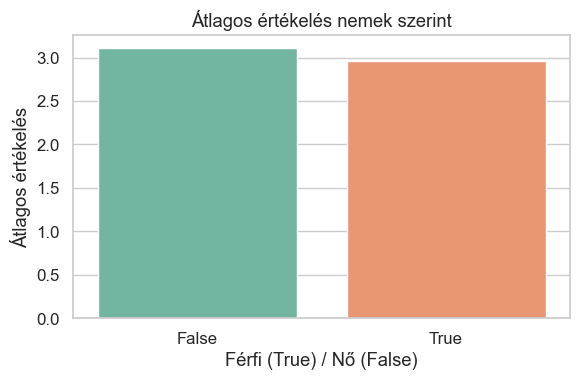

In [63]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_full,
    x="person_male",
    y="rating",
    estimator="mean",
    errorbar=None,
    palette="Set2"
)
plt.title("Átlagos értékelés nemek szerint")
plt.xlabel("Férfi (True) / Nő (False)")
plt.ylabel("Átlagos értékelés")
plt.tight_layout()
plt.show()


# Értékelések eloszlása

Ebben a vizualizációban azt mutatjuk be, hogy a felhasználók által adott filmértékelések hogyan oszlanak el.

- **Adatok:** `df_full` DataFrame, `rating` oszlop (1–5 értékelés).  
- **Vizualizáció típusa:** histogram (`histplot`) a Seaborn könyvtárral, kde görbével a trend kiemeléséhez.  
- **Beállítások:**
  - `bins=5` → 5 osztályba soroljuk az értékeléseket (1,2,3,4,5).  
  - `kde=True` → hozzáadjuk a simított sűrűség görbét a trend vizualizálásához.  
  - `color="#4C72B0"` → egységes kék szín a histogramhoz.  

Ez az ábra lehetővé teszi, hogy gyorsan átlássuk, **mely értékelések a leggyakoribbak**, és milyen a felhasználók által adott pontszámok eloszlása.


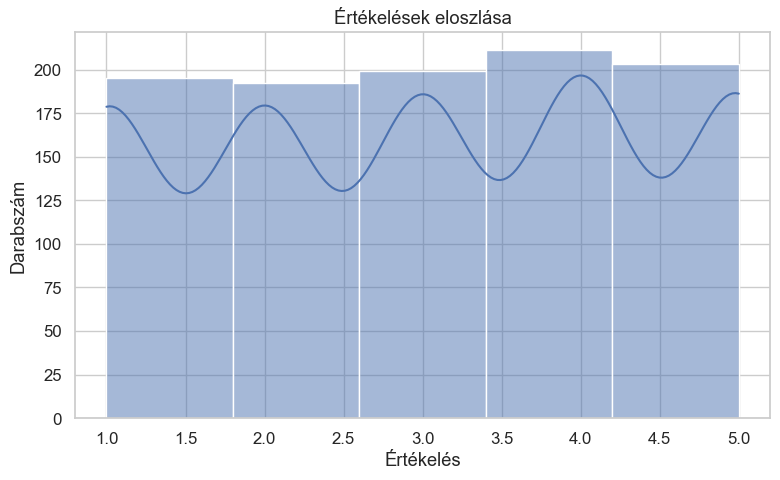

In [64]:
plt.figure(figsize=(8,5))
sns.histplot(
    df_full["rating"],
    bins=5,
    kde=True,
    color="#4C72B0"
)
plt.title("Értékelések eloszlása")
plt.xlabel("Értékelés")
plt.ylabel("Darabszám")
plt.tight_layout()
plt.show()


# Vélemények száma időben (színátmenet)

Ebben a vizualizációban azt mutatjuk be, hogy **hónapról hónapra hogyan változott a vélemények száma**, kiemelve a trendeket színátmenettel.

- **Adatok:** `df_by_month` DataFrame, amely a vélemények számát tartalmazza hónapokra bontva (`count`), és a hónapok dátumát (`date`).  
- **Vizualizáció típusa:** vonaldiagram (`plot`) színátmenettel és kiemelt pontokkal (`scatter`).  
- **Beállítások:**
  - `colors = plt.cm.viridis(...)` → a véleményszám alapján színátmenetet állítunk be (alacsony érték világos, magas érték sötét).  
  - `plt.plot(...)` → összeköti a hónapokat vonallal, minden szakasz a színátmenetnek megfelelően.  
  - `plt.scatter(...)` → minden pont kiemelve, fekete szegéllyel a jobb láthatóságért.  
  - `plt.xticks(rotation=45)` → a dátumok olvashatóbbak elforgatva.  
  - `plt.tight_layout()` → biztosítja, hogy a címek és tengelyek ne essenek ki az ábrából.  

Ez az ábra gyorsan áttekintést ad arról, hogy **mely hónapokban volt a legtöbb vélemény**, és vizuálisan is kiemeli a trendeket színátmenettel.


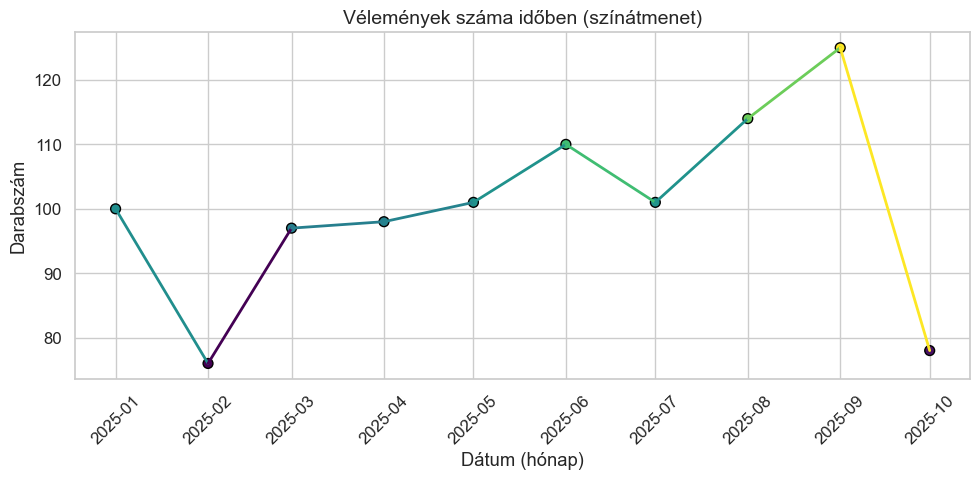

In [65]:
import numpy as np

x = df_by_month["date"]
y = df_by_month["count"]
colors = plt.cm.viridis((y - y.min()) / (y.max() - y.min()))  # normálva 0-1 közé

plt.figure(figsize=(10,5))
for i in range(len(x)-1):
    plt.plot(x[i:i+2], y[i:i+2], color=colors[i], linewidth=2)
plt.scatter(x, y, c=colors, s=50, edgecolor="black")
plt.title("Vélemények száma időben (színátmenet)", fontsize=14)
plt.xlabel("Dátum (hónap)")
plt.ylabel("Darabszám")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Korrelációs mátrix

Ebben a vizualizációban a numerikus változók közötti **kapcsolatokat** vizsgáljuk a `df_full` DataFrame alapján.

- **Numerikus oszlopok:**  
  - `rating` → vélemény értékelés  
  - `person_age` → felhasználó életkora  
  - `person_male` → felhasználó neme (True/Férfi, False/Nő)  
  - `movie_year` → film megjelenési éve  

- **Vizualizáció típusa:** hőtérkép (`heatmap`) Seaborn segítségével.
- **Beállítások:**
  - `annot=True` → az értékeket kiírja a cellákba.  
  - `fmt=".2f"` → két tizedesjegyre formázza a korrelációkat.  
  - `cmap="coolwarm"` → kék-piros színátmenet a negatív és pozitív korrelációkhoz.  
  - `vmin=-1, vmax=1` → a színtartomány a teljes korrelációs skálát lefedi (-1 és 1 között).  

Ez a hőtérkép lehetővé teszi, hogy gyorsan átlássuk, mely numerikus változók **pozitív vagy negatív kapcsolatban állnak egymással**, és segít az esetleges trendek és összefüggések feltárásában.


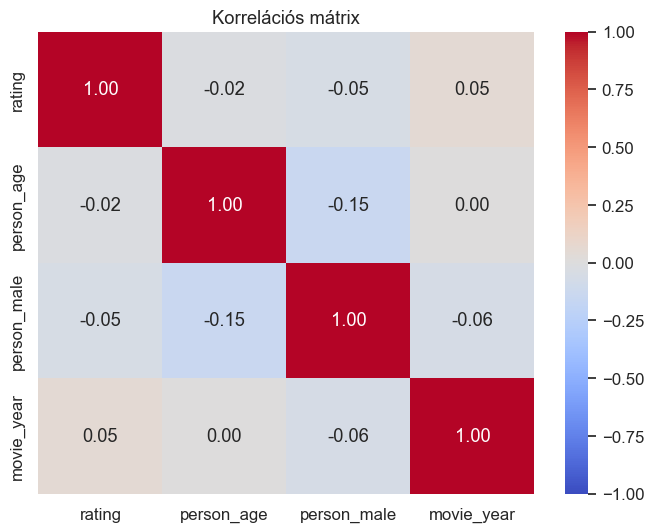

In [66]:
# Kiválasztjuk a numerikus oszlopokat
numeric_cols = ["rating", "person_age", "person_male", "movie_year"]
corr = df_full[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Korrelációs mátrix")
plt.show()